In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [2]:
data_df = pd.read_pickle('cleaned_data.pkl')
y_label = pd.read_pickle('label.pkl')
feature_columns = data_df.columns

In [3]:
# train test splitting
X_train, X_test, y_train, y_test = train_test_split(data_df[feature_columns], y_label, test_size=0.33, random_state=42)

In [4]:
y_label.sum()/float(len(y_label))

0.09599731350615846

* Imbalanced classes

### Grid Search for RandomForest

In [5]:
RF = RandomForestClassifier(class_weight='balanced')

In [7]:
tuned_parameters = [{'n_estimators': [20,40,80]}]
scores = ['roc_auc']

for score in scores:
    print "# Tuning hyper-parameters for %s" % score
    print 

    clf = GridSearchCV(RF, tuned_parameters, cv=5,
                       scoring = score,verbose=True)
    clf.fit(X_train, y_train)

    print "Best parameters set found on development set:",clf.best_params_
    print
    print "Grid scores on development set:"
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print "%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params)
    print

    print "Detailed classification report:"
    print 
    print "The model is trained on the full development set."
    print "The scores are computed on the full evaluation set."
    print 
    y_true, y_pred,y_prob = y_test, clf.predict(X_test),clf.predict_proba(X_test)
    print classification_report(y_true, y_pred)
    print


# Tuning hyper-parameters for roc_auc

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 50.5min finished


Best parameters set found on development set: {'n_estimators': 80}

Grid scores on development set:
0.996 (+/-0.000) for {'n_estimators': 20}
0.998 (+/-0.000) for {'n_estimators': 40}
0.999 (+/-0.000) for {'n_estimators': 80}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       1.00      1.00      1.00    598528
          1       1.00      0.98      0.99     63808

avg / total       1.00      1.00      1.00    662336




In [8]:
RF_tune_results = pd.DataFrame({'num_trees': [20,40,80],
                                'test_score':clf.cv_results_['mean_test_score'],
                                'train_score':clf.cv_results_['mean_train_score']}
                              )
RF_tune_results

,num_trees,test_score,train_score
0,20,0.996292,1.0
1,40,0.998004,1.0
2,80,0.999043,1.0


In [10]:
def RF_feature_rank(model,topk=15):
    # get feature names
    feature_names = X_train.columns
    # get feature average score
    feature_mean_score = model.best_estimator_.feature_importances_
    # get feature score (list of array)
    scores = [tree.feature_importances_ for tree in model.best_estimator_.estimators_]
    # change to a numpy array 
    scores_array = np.array(scores)
    # calculate standard deviation for each feature (column direction)
    score_std = np.std(scores_array, axis=0)
    
    # create a dataframe
    feature_df = pd.DataFrame({'feature_names':feature_names,
                               'feature_score':feature_mean_score,
                               'score_std':score_std})
    # get most siginificant features 
    top_features = feature_df.sort_values('feature_score').iloc[-topk:]
    # generate bar plot
    fig,ax=plt.subplots()
    ax = top_features['feature_score'].plot.barh(xerr=top_features['score_std'],title='feature_importances')
    ax.set_xlabel('feature score')
    ax.set_ylabel('features')
    ax.set_yticklabels(top_features['feature_names'])

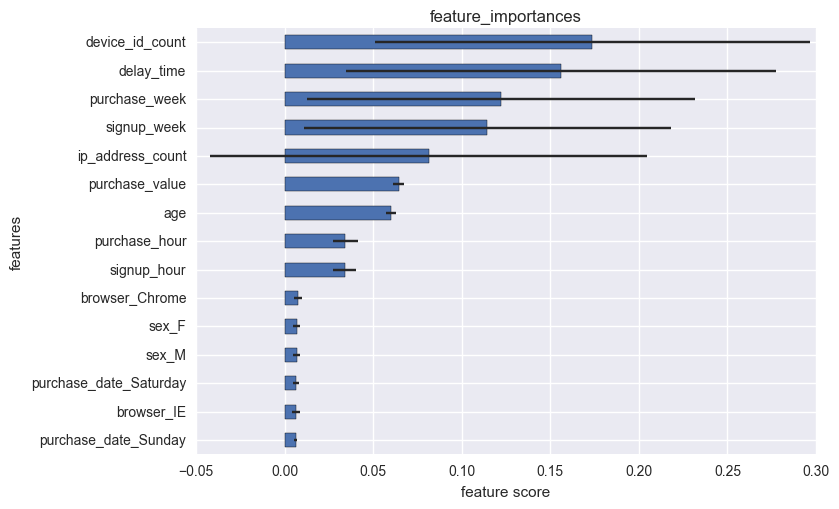

In [11]:
RF_feature_rank(clf)

In [12]:
def plot_confusion_matrix(ytest,ypredict):
    cm =confusion_matrix(ytest, ypredict)
    row_sums = cm.astype('float').sum(axis=1,keepdims=True)
    RF_cm = cm / row_sums
    plt.figure(figsize=(4, 3))
    ax = sns.heatmap(RF_cm,annot=True)
    ax.set(xlabel='Predicted Label',ylabel='True Label')

In [13]:
def plot_binary_ROC(ytest,yprob):
    fpr,tpr,_= roc_curve(ytest,yprob)
    roc_auc = auc(fpr,tpr)
    plt.figure()
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve(area = %0.2f)' %roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=2,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc='lower right')
    

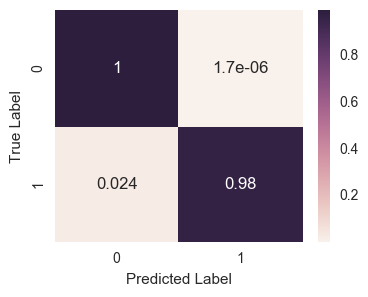

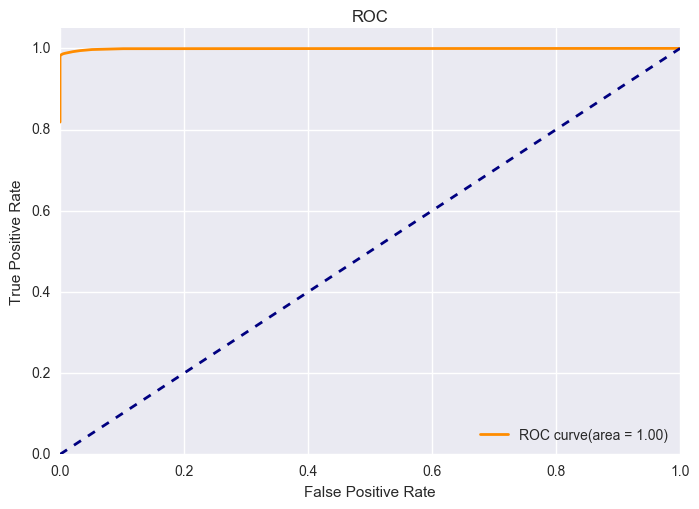

In [14]:
plot_confusion_matrix(y_true,y_pred)
plot_binary_ROC(y_true,y_prob[:,1])